# Metric results comp notebook
This notebook just calcs and compares metrics of different models preds on the test set

In [1]:
import torch
import os
import sys
import torchmetrics
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [2]:
sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from util_folder.ml_utils.result_utils.plot_utils import plotNet
from util_folder.dotdict import DotDict
from util_folder.ml_utils.result_utils.metric_utils import (generate_masks, 
                                                            MetricObj, 
                                                            calc_aggregates, 
                                                            create_res_df, 
                                                            create_test_metrics)
from util_folder.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits

In [3]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

In [6]:
base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/informed_baseline_comp/'
model_names = os.listdir(base_dir)
model_names = ['inf_lstm', 'inf_attention', 'netinf_lstm', 'netinf_attention', 'inf_dcrnn']
random_seeds = [41,42,43,44]

y_true = torch.load(f'{base_dir}/{model_names[0]}/y_true_{random_seeds[0]}.pt').cpu()

In [7]:
results_dict = {}
for name in model_names:
    results_dict[name] = {}
    for seed in random_seeds:
        results_dict[name][seed] = torch.load(f'{base_dir}/{name}/y_hat_{seed}.pt').cpu()
        assert (torch.load(f'{base_dir}/{name}/y_true_{seed}.pt').cpu() - y_true).sum() == 0

In [8]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)

*** DATA SUMMARY: ***
input_full.shape=torch.Size([10270, 147, 6, 10, 5])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [9]:
metric_obj = MetricObj(bce_pos_weight=25.5191)

full_test = {}
for model in model_names:
    full_test[model] = {}
    for seed in random_seeds:
        full_test[model][seed] = metric_obj.calc_metrics(y_hat=results_dict[model][seed], y_true=y_true)
full_test_aggregates = calc_aggregates(full_test, model_names, random_seeds)
full_test_df = create_res_df(full_test_aggregates)
del full_test

upstream_test_df, not_upstream_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, upstream_mask)
multilane_test_df, not_multilane_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, multilane_mask)
highway_test_df, not_highway_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, highway_mask)
spreading_test_df, not_spreading_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, spreading_mask)
affected_test_df, not_affected_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_mask)

In [10]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, n_hop_mask)
    n_hop_dfs[hop] = temp_df

In [11]:
affected_n_hop_dfs = {}
for hop in range(11):
    affected_n_hop_mask = (test_dataset.network_info[:,:,0] == -hop) & affected_mask
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_n_hop_mask)
    affected_n_hop_dfs[hop] = temp_df

In [12]:
df_arr = [full_test_df,
          upstream_test_df, not_upstream_test_df,
          multilane_test_df, not_multilane_test_df, 
          highway_test_df, not_highway_test_df, 
          spreading_test_df, not_spreading_test_df]


In [13]:

def print_res_df(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys().get_level_values(0).unique():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            mean = res_dict[loss_part][metric]["mean"]
            std = res_dict[loss_part][metric]["std"]
            metric_str +=  f'{metric} : {mean:.03f} ({std:.03f}) \t'
        print(metric_str)

In [14]:
#for model in full_test_df.keys().get_level_values(0):
    #print_res_dict(full_test_df[model], model)
pd.set_option('display.max_rows', 500)
full_test_df.T

mean            std
inf_lstm         end   mae    3.868742e+00       0.395214
                       mape   1.315935e+06  371013.187500
                       Mmape  9.306478e-01       0.016629
                 start mae    1.212502e+00       0.109418
                       mape   3.962903e+05  103320.726562
                       Mmape  9.156904e-01       0.017354
                 speed mae    1.221719e+00       0.086504
                       mape   3.781255e+05   71757.468750
                       Mmape  9.403559e-01       0.005825
                 class acc    8.789644e-01       0.044520
                       f1     1.535780e-01       0.013385
                       prcsn  1.190823e-01       0.018092
                       rcll   3.197168e-01       0.149372
inf_attention    end   mae    3.800687e+00       0.554303
                       mape   1.229602e+06  550293.000000
                       Mmape  9.413715e-01       0.033104
                 start mae    1.239717e+00       0.071302
                       mape   4.118208e+05   77599.851562
                       Mmape  9.284016e-01       0.031973
                 speed mae    1.286915e+00       0.029195
                       mape   4.299650e+05   39121.792969
                       Mmape  9.461383e-01       0.021185
                 class acc    8.358645e-01       0.090383
                       f1     9.547696e-02       0.064969
                       prcsn  6.482049e-02       0.043453
                       rcll   3.508926e-01       0.250454
netinf_lstm      end   mae    3.783639e+00       0.109168
                       mape   1.629958e+06   38837.914062
                       Mmape  7.283542e-01       0.033733
                 start mae    1.218719e+00       0.045494
                       mape   5.223569e+05   17224.164062
                       Mmape  6.897036e-01       0.038689
                 speed mae    1.300153e+00       0.066457
                       mape   5.517085e+05   35821.582031
                       Mmape  7.714178e-01       0.032026
                 class acc    8.349736e-01       0.059458
                       f1     2.685204e-01       0.036096
                       prcsn  1.815867e-01       0.044281
                       rcll   8.830798e-01       0.007186
netinf_attention end   mae    3.708319e+00       0.215781
                       mape   1.539950e+06   57672.550781
                       Mmape  7.462124e-01       0.051285
                 start mae    1.235140e+00       0.103732
                       mape   5.173567e+05   49424.921875
                       Mmape  7.330471e-01       0.064826
                 speed mae    1.231390e+00       0.073814
                       mape   4.921015e+05   35309.988281
                       Mmape  7.730266e-01       0.061694
                 class acc    8.641509e-01       0.017989
                       f1     2.689030e-01       0.041709
                       prcsn  1.926629e-01       0.026797
                       rcll   8.079765e-01       0.101887
inf_dcrnn        end   mae    2.556521e+00       0.100629
                       mape   1.001877e+06   77356.625000
                       Mmape  4.878888e-01       0.011920
                 start mae    8.719670e-01       0.022980
                       mape   3.230272e+05   24012.335938
                       Mmape  4.829942e-01       0.031072
                 speed mae    7.676415e-01       0.025426
                       mape   3.026236e+05   18511.802734
                       Mmape  5.022999e-01       0.019142
                 class acc    9.471928e-01       0.005140
                       f1     5.498592e-01       0.028061
                       prcsn  4.147227e-01       0.023823
                       rcll   9.633937e-01       0.011511

# Inf_lstm

In [15]:
focus_model = 'inf_lstm'

In [16]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.868742  1.315935e+06  0.930648  1.212502  396290.312500  0.915690   
std   0.395214  3.710132e+05  0.016629  0.109418  103320.726562  0.017354   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.221719  378125.46875  0.940356  0.878964  0.153578  0.119082  0.319717  
std   0.086504   71757.46875  0.005825  0.044520  0.013385  0.018092  0.149372

In [17]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.194544  1.582294e+06  0.930648  5.502243  486445.093750  0.915690   
std    0.123058  3.183900e+05  0.016629  0.037817   94337.148438  0.017354   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.601889  400048.406250  0.940356  0.710302  0.431154  0.396621   
std   0.014911   29484.021484  0.005825  0.019895  0.072030  0.003167   

                
          rcll  
mean  0.319717  
std   0.149372

In [18]:
not_upstream_test_df[focus_model]

end                         start                        speed  \
           mae          mape Mmape       mae         mape Mmape       mae   
mean  1.483871  1.268266e+06   NaN  0.444782  380155.6875   NaN  0.437816   
std   0.445139  3.804604e+05   NaN  0.123082  105198.0625   NaN  0.102057   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  374202.000000   NaN  0.909149  0.0   0.0  0.0  
std    87227.828125   NaN  0.048930  0.0   0.0  0.0

In [19]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.723752  1.322653e+06  0.928369  1.474551  397088.000000  0.913301   
std   0.416372  4.048058e+05  0.017803  0.117061  114332.742188  0.018767   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.523377  392522.812500  0.938202  0.869394  0.193061  0.160401   
std   0.108248   90234.578125  0.005774  0.045169  0.012876  0.031033   

                
          rcll  
mean  0.338856  
std   0.160355

In [20]:
not_multilane_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae           mape    Mmape   
mean  2.763717  1.307254e+06  0.937431  0.873825  395259.406250  0.92280   
std   0.385026  3.435358e+05  0.013904  0.110126   98580.960938  0.01467   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.831853  359518.156250  0.946765  0.891333  0.086806  0.061160   
std   0.069418   58341.398438  0.007882  0.043840  0.011199  0.008603   

                
          rcll  
mean  0.262762  
std   0.117875

In [21]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.170460  1.350609e+06  0.927250  1.331402  406162.312500  0.915156   
std   0.416481  3.969868e+05  0.018496  0.116076  111215.828125  0.018884   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.360368  395129.000000  0.938100  0.873035  0.168735  0.131394   
std   0.098197   82630.179688  0.005503  0.046180  0.011723  0.018026   

                
          rcll  
mean  0.335276  
std   0.161914

In [22]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.369776  1.258593e+06  0.938356  1.015871  379964.531250  0.916903   
std   0.371094  3.385567e+05  0.012905  0.104592   96013.359375  0.014977   

         speed                             class                                
           mae           mape     Mmape      acc        f1     prcsn      rcll  
mean  0.992430  350005.937500  0.945473  0.88877  0.123377  0.096276  0.284421  
std   0.073665   60359.828125  0.008714  0.04193  0.015995  0.020403  0.121882

In [23]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.478598  1.685585e+06  0.928546  1.717402  507648.593750  0.912957   
std   0.499630  4.779245e+05  0.017101  0.138255  133168.546875  0.017848   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.715142  485866.125000  0.938266  0.840377  0.175603  0.139022   
std   0.113502   93501.078125  0.006133  0.055916  0.013283  0.021399   

                
          rcll  
mean  0.331748  
std   0.154750

In [24]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  0.892405  632519.937500  0.977317  0.279031  190408.718750  0.976386   
std   0.203846  175213.234375  0.007399  0.057260   49238.476562  0.007621   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.309469  178932.171875  0.986767  0.950305  0.009128  0.004956   
std   0.038026   32666.855469  0.002623  0.023464  0.000633  0.001170   

                
          rcll  
mean  0.052551  
std   0.031808

In [25]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  61.845299  0.930648  0.930648  19.884251  0.915690  0.915690  20.693350   
std    1.052040  0.016629  0.016629   0.307704  0.017354  0.017354   0.110151   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.940356  0.940356  0.319717  0.663437   1.0  0.319717  
std   0.005825  0.005825  0.149372  0.153258   0.0  0.149372

In [26]:
not_affected_test_df[focus_model]

end                        start                         speed  \
           mae         mape Mmape       mae          mape Mmape       mae   
mean  1.599896  1367432.875   NaN  0.481804  411798.62500   NaN  0.459720   
std   0.451073   385532.375   NaN  0.125616  107364.03125   NaN  0.087242   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  392922.875000   NaN  0.900850  0.0   0.0  0.0  
std    74565.585938   NaN  0.052093  0.0   0.0  0.0

In [27]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.36	 0.28	 0.90	 0.12	 8.59	 35.80	 17.40
1:	 0.46	 0.45	 0.90	 0.16	 7.33	 31.82	 13.33
2:	 0.51	 0.57	 0.82	 0.21	 7.10	 27.97	 10.80
3:	 0.56	 0.63	 0.70	 0.26	 7.10	 25.59	 9.13
4:	 0.57	 0.67	 0.66	 0.31	 7.05	 25.00	 8.21
5:	 0.58	 0.71	 0.60	 0.36	 6.61	 23.45	 7.27
6:	 0.58	 0.73	 0.58	 0.40	 6.68	 22.59	 6.86
7:	 0.59	 0.74	 0.56	 0.44	 6.92	 21.87	 6.51
8:	 0.56	 0.75	 0.51	 0.46	 6.89	 20.17	 5.99
9:	 0.54	 0.75	 0.48	 0.47	 7.37	 19.96	 5.66
10:	 0.53	 0.77	 0.48	 0.52	 7.45	 18.47	 5.06


In [28]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.37	 0.12	 1.00	 0.12	 10.64	 44.39	 21.62
1:	 0.47	 0.16	 1.00	 0.16	 11.23	 48.81	 20.47
2:	 0.55	 0.21	 1.00	 0.21	 13.63	 53.79	 20.85
3:	 0.62	 0.26	 1.00	 0.26	 15.81	 57.16	 20.54
4:	 0.67	 0.31	 1.00	 0.31	 17.45	 62.10	 20.58
5:	 0.73	 0.36	 1.00	 0.36	 18.50	 65.99	 20.63
6:	 0.76	 0.40	 1.00	 0.40	 20.22	 68.59	 21.03
7:	 0.79	 0.44	 1.00	 0.44	 22.31	 70.35	 21.16
8:	 0.79	 0.46	 1.00	 0.46	 24.82	 71.91	 21.65
9:	 0.81	 0.47	 1.00	 0.47	 28.07	 74.67	 21.36
10:	 0.84	 0.52	 1.00	 0.52	 31.46	 75.83	 20.91


Text(0.5, 1.0, 'inf_lstm')

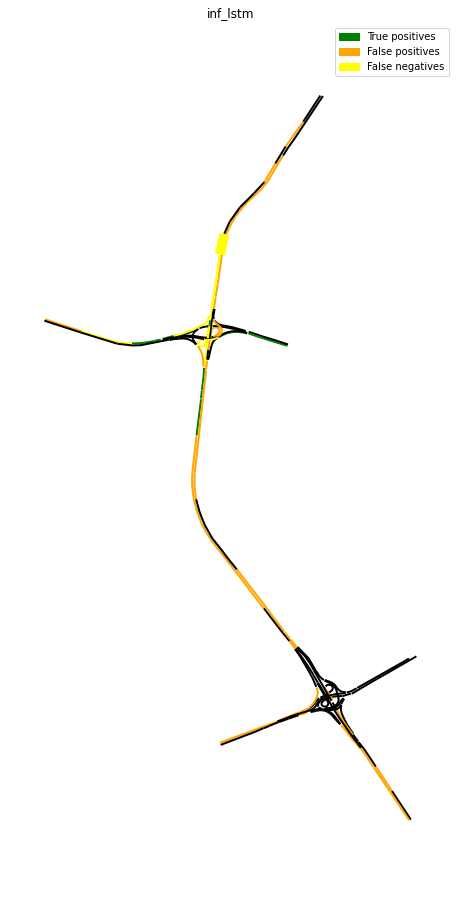

In [29]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_lstm')

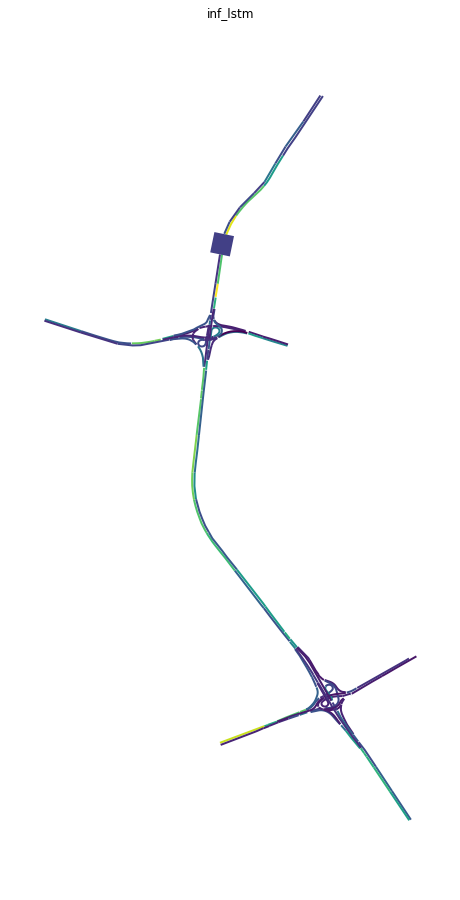

In [30]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

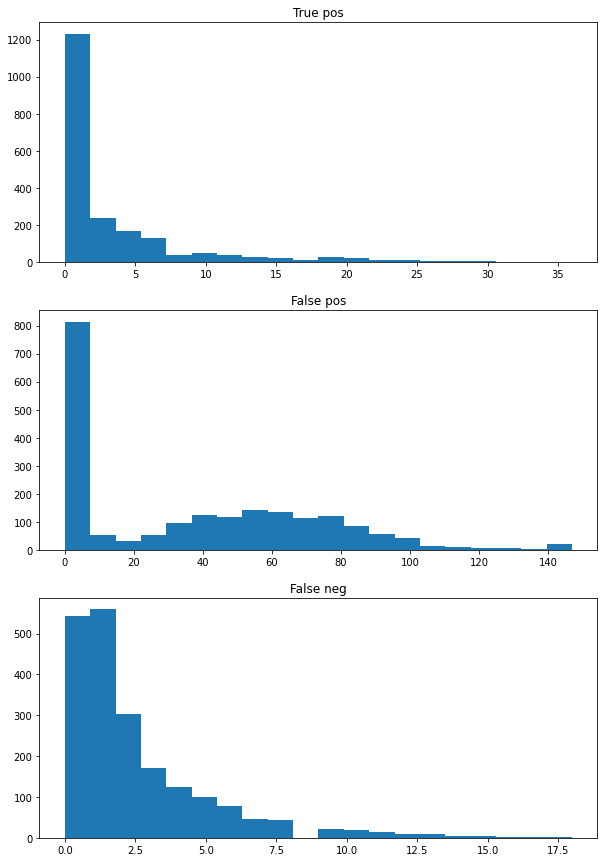

In [31]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Inf_attention

In [32]:
focus_model = 'inf_attention'

In [33]:
full_test_df[focus_model]

end                          start                           \
           mae       mape     Mmape       mae           mape     Mmape   
mean  3.800687  1229602.5  0.941372  1.239717  411820.750000  0.928402   
std   0.554303   550293.0  0.033104  0.071302   77599.851562  0.031973   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.286915  429964.968750  0.946138  0.835864  0.095477  0.064820   
std   0.029195   39121.792969  0.021185  0.090383  0.064969  0.043453   

                
          rcll  
mean  0.350893  
std   0.250454

In [34]:
upstream_test_df[focus_model]

end                            start                           \
            mae         mape     Mmape       mae           mape     Mmape   
mean  17.204174  1404970.500  0.941372  5.523526  453705.812500  0.928402   
std    0.251410   722353.625  0.033104  0.016840  140077.078125  0.031973   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.667952  430927.906250  0.946138  0.687759  0.329396  0.273576   
std   0.019977   94227.335938  0.021185  0.045147  0.223597  0.182470   

                
          rcll  
mean  0.350893  
std   0.250454

In [35]:
not_upstream_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.401914  1.198218e+06   NaN  0.473060  404324.687500   NaN  0.502857   
std   0.608820  5.203595e+05   NaN  0.081148   69357.429688   NaN  0.034313   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  429792.593750   NaN  0.862370  0.0   0.0  0.0  
std    29327.646484   NaN  0.098489  0.0   0.0  0.0

In [36]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.608428  1.182870e+06  0.940753  1.494978  403606.812500  0.927068   
std   0.485822  5.209272e+05  0.033672  0.063154   76158.257812  0.033365   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.561880  418775.000000  0.945763  0.835906  0.126475  0.089774   
std   0.017745   34171.132812  0.021964  0.080802  0.086670  0.060227   

                
          rcll  
mean  0.360387  
std   0.257917

In [37]:
not_multilane_test_df[focus_model]

end                             start                         \
           mae          mape     Mmape       mae         mape     Mmape   
mean  2.756755  1.290000e+06  0.943213  0.909816  422436.4375  0.932370   
std   0.642815  5.882821e+05  0.031484  0.083798   79921.3125  0.027927   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.931548  444426.968750  0.947254  0.835810  0.052589  0.033763   
std   0.046089   46251.886719  0.018917  0.102834  0.035302  0.022630   

                
          rcll  
mean  0.322640  
std   0.228329

In [38]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.062383  1.224354e+06  0.939610  1.350044  413204.687500  0.928340   
std   0.539051  5.485523e+05  0.034403  0.072682   81236.578125  0.032533   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.406444  428926.187500  0.945756  0.835387  0.107548  0.073810   
std   0.026886   39610.402344  0.022046  0.087638  0.073550  0.049554   

                
          rcll  
mean  0.358971  
std   0.257630

In [39]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.367909  1.238282e+06  0.945367  1.057265  409532.000000  0.928540   
std   0.579573  5.531902e+05  0.030165  0.069494   71833.953125  0.030799   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.089246  431682.812500  0.947006  0.836653  0.074581  0.049965   
std   0.033048   38436.679688  0.019281  0.094926  0.050218  0.033391   

                
          rcll  
mean  0.332567  
std   0.234709

In [40]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.333230  1.517887e+06  0.939810  1.719133  497135.218750  0.926414   
std   0.748057  7.565858e+05  0.034324  0.130603  139700.734375  0.033604   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.745919  505897.812500  0.944628  0.793538  0.116173  0.079667   
std   0.089289   98502.421875  0.022266  0.111655  0.077763  0.053356   

                
          rcll  
mean  0.362536  
std   0.259178

In [41]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  0.967292  696615.62500  0.976049  0.353363  254089.500000  0.972544   
std   0.197283  169551.59375  0.007333  0.061687   53034.628906  0.009050   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.438301  289578.656250  0.979683  0.914119  0.007281  0.003913   
std   0.087085   74712.914062  0.002840  0.055129  0.004855  0.002616   

                
          rcll  
mean  0.092347  
std   0.062044

In [42]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  62.720383  0.941372  0.941372  20.124435  0.928402  0.928402  20.814005   
std    2.393326  0.033104  0.033104   0.602510  0.031973  0.031973   0.445165   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.946138  0.946138  0.350893  0.555498  0.75  0.350893  
std   0.021185  0.021185  0.250454  0.377064  0.50  0.250454

In [43]:
not_affected_test_df[focus_model]

end                         start                         speed  \
           mae          mape Mmape       mae          mape Mmape       mae   
mean  1.494934  1.277721e+06   NaN  0.500686  427936.81250   NaN  0.522746   
std   0.669039  5.718281e+05   NaN  0.094345   80636.65625   NaN  0.047564   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  446791.125000   NaN  0.854843  0.0   0.0  0.0  
std    40652.828125   NaN  0.103657  0.0   0.0  0.0

In [44]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.36	 0.31	 0.65	 0.16	 8.62	 35.97	 17.40
1:	 0.42	 0.47	 0.64	 0.22	 7.41	 32.08	 13.38
2:	 0.43	 0.58	 0.57	 0.26	 7.21	 28.27	 10.89
3:	 0.45	 0.64	 0.51	 0.31	 7.21	 25.90	 9.24
4:	 0.45	 0.67	 0.47	 0.36	 7.16	 25.28	 8.32
5:	 0.45	 0.69	 0.42	 0.40	 6.70	 23.70	 7.37
6:	 0.44	 0.71	 0.40	 0.43	 6.78	 22.82	 6.96
7:	 0.43	 0.72	 0.39	 0.46	 7.03	 22.14	 6.62
8:	 0.41	 0.73	 0.35	 0.48	 6.96	 20.33	 6.09
9:	 0.40	 0.72	 0.33	 0.49	 7.43	 20.09	 5.75
10:	 0.38	 0.72	 0.30	 0.51	 7.51	 18.62	 5.15


In [45]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.37	 0.16	 0.75	 0.16	 10.66	 44.60	 21.59
1:	 0.44	 0.22	 0.75	 0.22	 11.30	 49.13	 20.48
2:	 0.48	 0.26	 0.75	 0.26	 13.75	 54.30	 20.90
3:	 0.53	 0.31	 0.75	 0.31	 16.02	 57.89	 20.65
4:	 0.57	 0.36	 0.75	 0.36	 17.69	 62.91	 20.69
5:	 0.60	 0.40	 0.75	 0.40	 18.78	 66.92	 20.79
6:	 0.62	 0.43	 0.75	 0.43	 20.55	 69.67	 21.21
7:	 0.63	 0.46	 0.75	 0.46	 22.72	 71.66	 21.37
8:	 0.64	 0.48	 0.75	 0.48	 25.18	 73.12	 21.82
9:	 0.65	 0.49	 0.75	 0.49	 28.44	 75.96	 21.57
10:	 0.66	 0.51	 0.75	 0.51	 31.93	 77.43	 21.17


Text(0.5, 1.0, 'inf_attention')

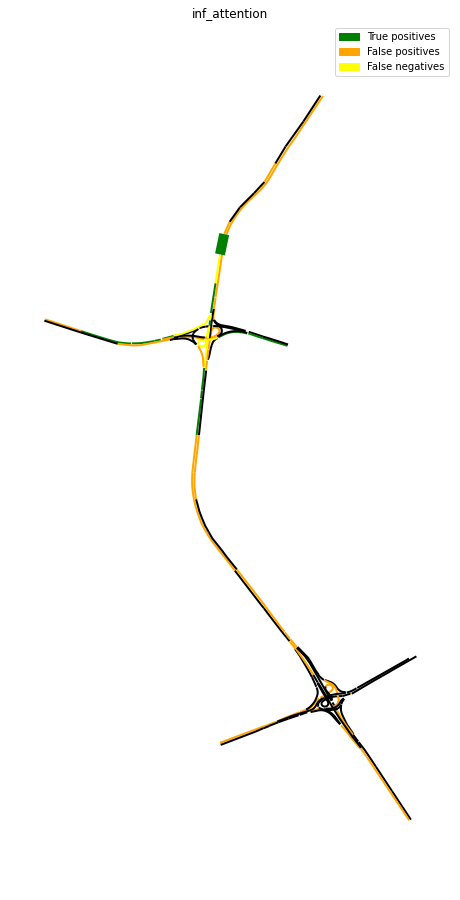

In [46]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_attention')

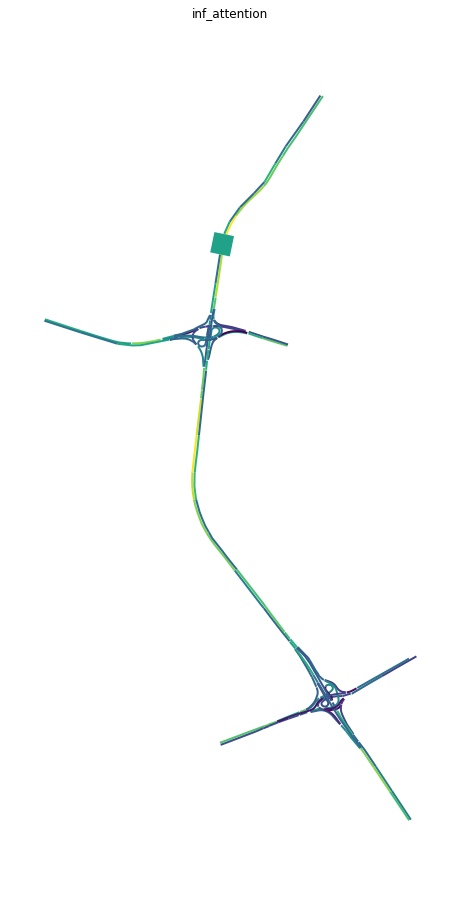

In [47]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

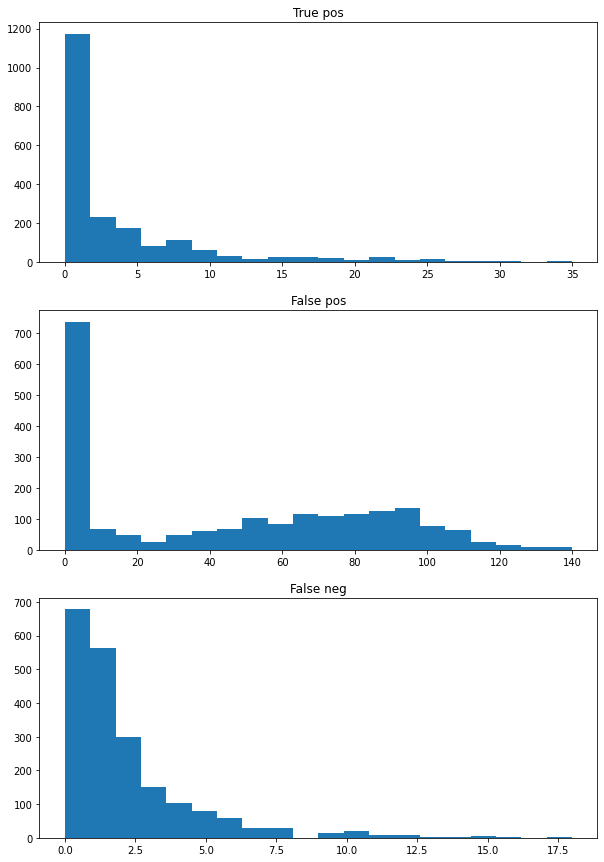

In [48]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# NetInf-LSTM

In [49]:
focus_model = 'netinf_lstm'

In [50]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.783639  1.629958e+06  0.728354  1.218719  522356.875000  0.689704   
std   0.109168  3.883791e+04  0.033733  0.045494   17224.164062  0.038689   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.300153  551708.500000  0.771418  0.834974  0.268520  0.181587   
std   0.066457   35821.582031  0.032026  0.059458  0.036096  0.044281   

                
          rcll  
mean  0.883080  
std   0.007186

In [51]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  20.222683  6.718280e+06  0.728354  6.524910  2.155994e+06  0.689704   
std    0.446187  9.083107e+05  0.033733  0.322798  4.255259e+05  0.038689   

         speed                            class                                
           mae         mape     Mmape       acc        f1     prcsn      rcll  
mean  6.754669  2087218.375  0.771418  0.339126  0.394597  0.258887  0.883080  
std   0.216105   299097.875  0.032026  0.073013  0.003217  0.022956  0.007186

In [52]:
not_upstream_test_df[focus_model]

end                          start                          speed  \
           mae           mape Mmape       mae           mape Mmape       mae   
mean  0.841603  719319.062500   NaN  0.269089  229990.703125   NaN  0.323978   
std   0.193379  165281.234375   NaN  0.100443   85848.929688   NaN  0.106410   

                             class                  
              mape Mmape       acc   f1 prcsn rcll  
mean  276903.87500   NaN  0.923714  0.0   0.0  0.0  
std    90948.53125   NaN  0.059951  0.0   0.0  0.0

In [53]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.530979  1.686536e+06  0.727556  1.453910  544835.937500  0.688425   
std   0.162830  4.447603e+04  0.035609  0.068271   25332.876953  0.041015   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.585401  590273.625000  0.769950  0.819046  0.308835  0.215250   
std   0.079013   37728.039062  0.034067  0.064305  0.039023  0.051831   

                
          rcll  
mean  0.904388  
std   0.012822

In [54]:
not_multilane_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  2.817769  1.556835e+06  0.730729  0.914756  493304.59375  0.693509   
std   0.053425  4.593968e+04  0.028859  0.018197   11619.71582  0.034068   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.931495  501866.500000  0.775787  0.855558  0.191370  0.119807   
std   0.055656   40216.335938  0.026633  0.053447  0.028341  0.029107   

                
          rcll  
mean  0.819668  
std   0.031526

In [55]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.545315  2.108886e+06  0.723262  1.487090  676540.687500  0.694060   
std   0.098636  6.062174e+04  0.037863  0.045554   18662.589844  0.042525   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.582590  705636.875000  0.770828  0.792075  0.246889  0.165199   
std   0.065018   30302.484375  0.034636  0.068506  0.031724  0.038828   

                
          rcll  
mean  0.906646  
std   0.011680

In [56]:
not_highway_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.524020  837931.500000  0.739905  0.774901  267375.843750  0.679821   
std   0.137766   58318.042969  0.025481  0.047990   24175.166016  0.032545   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.833071  297150.000000  0.772755  0.905918  0.338092  0.241951   
std   0.069203   45649.542969  0.026304  0.044699  0.052310  0.067125   

                
          rcll  
mean  0.829621  
std   0.023211

In [57]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.060214  1.916436e+06  0.721875  1.619987  607969.000000  0.681805   
std   0.083307  1.010506e+05  0.036233  0.040266   19660.222656  0.041339   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.674395  611708.500000  0.765944  0.828740  0.351648  0.237764   
std   0.037021   14509.348633  0.034167  0.042184  0.032675  0.042145   

                
          rcll  
mean  0.901572  
std   0.020197

In [58]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  1.423480  1.100310e+06  0.872244  0.476845  364075.312500  0.865108   
std   0.182404  1.583977e+05  0.022675  0.060619   52528.867188  0.020245   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.608245  440779.375000  0.892969  0.846498  0.033651  0.013966   
std   0.126409  109361.820312  0.017515  0.092022  0.005848  0.001904   

                
          rcll  
mean  0.472449  
std   0.333083

In [59]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  49.829693  0.728354  0.728354  16.132784  0.689704  0.689704  17.383236   
std    2.765113  0.033733  0.033733   0.795751  0.038689  0.038689   0.676872   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.771418  0.771418  0.883080  0.983641   1.0  0.883080  
std   0.032026  0.032026  0.007186  0.009726   0.0  0.007186

In [60]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.981681  1.693744e+06   NaN  0.635074  542798.625000   NaN  0.670760   
std   0.047219  4.035771e+04   NaN  0.020941   17898.203125   NaN  0.043551   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  573298.937500   NaN  0.833091  0.0   0.0  0.0  
std    37223.429688   NaN  0.061600  0.0   0.0  0.0

In [61]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.85	 0.64	 0.84	 0.69	 7.23	 31.34	 15.88
1:	 0.80	 0.71	 0.77	 0.80	 6.05	 27.44	 12.12
2:	 0.71	 0.67	 0.65	 0.87	 6.21	 24.89	 10.12
3:	 0.63	 0.63	 0.56	 0.91	 6.53	 23.67	 8.87
4:	 0.57	 0.58	 0.49	 0.93	 6.73	 23.74	 8.22
5:	 0.51	 0.52	 0.42	 0.94	 6.70	 23.49	 7.65
6:	 0.48	 0.48	 0.37	 0.95	 6.95	 23.18	 7.41
7:	 0.45	 0.45	 0.34	 0.95	 7.28	 22.75	 7.17
8:	 0.41	 0.40	 0.30	 0.96	 7.51	 21.81	 6.87
9:	 0.39	 0.37	 0.28	 0.96	 8.12	 22.04	 6.65
10:	 0.36	 0.33	 0.24	 0.97	 8.38	 21.14	 6.23


In [62]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.94	 0.69	 1.00	 0.69	 8.51	 37.54	 19.26
1:	 0.97	 0.80	 1.00	 0.80	 8.53	 39.94	 17.70
2:	 0.99	 0.87	 1.00	 0.87	 10.44	 43.49	 17.78
3:	 0.99	 0.91	 1.00	 0.91	 12.19	 45.88	 17.32
4:	 0.99	 0.93	 1.00	 0.93	 13.52	 49.71	 17.18
5:	 1.00	 0.94	 1.00	 0.94	 14.35	 52.89	 17.18
6:	 0.99	 0.95	 1.00	 0.95	 15.92	 54.94	 17.45
7:	 0.99	 0.95	 1.00	 0.95	 17.89	 56.30	 17.52
8:	 0.99	 0.96	 1.00	 0.96	 20.28	 57.24	 17.87
9:	 0.99	 0.96	 1.00	 0.96	 23.49	 59.96	 17.58
10:	 1.00	 0.97	 1.00	 0.97	 26.73	 60.56	 17.04


Text(0.5, 1.0, 'netinf_lstm')

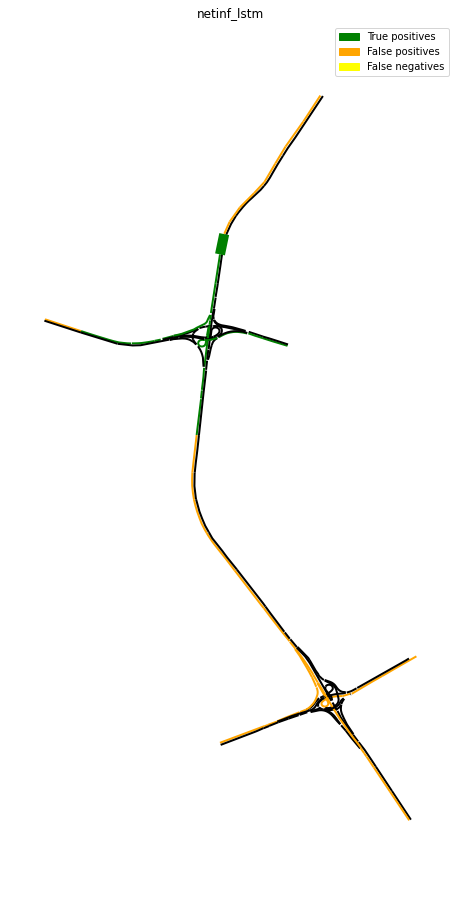

In [63]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'netinf_lstm')

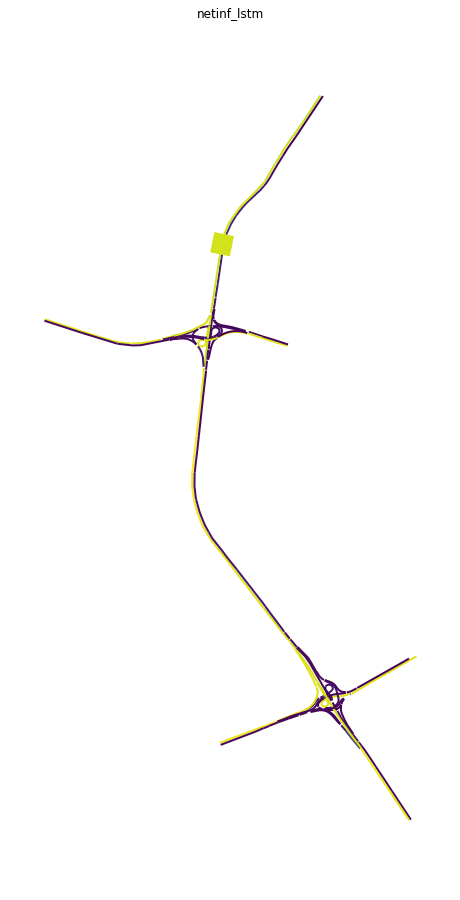

In [64]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

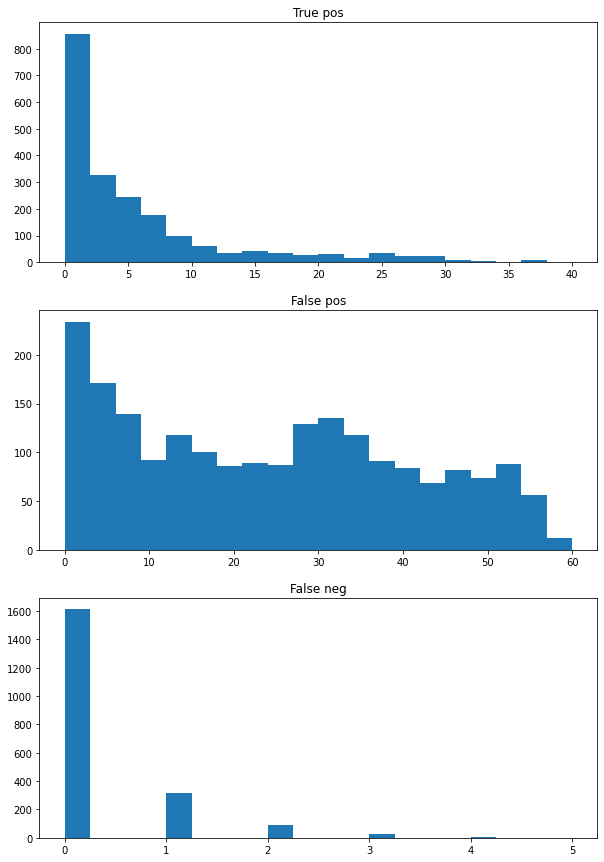

In [65]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# NetInf-attention

In [66]:
focus_model = 'netinf_attention'

In [67]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.708319  1.539950e+06  0.746212  1.235140  517356.687500  0.733047   
std   0.215781  5.767255e+04  0.051285  0.103732   49424.921875  0.064826   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.231390  492101.500000  0.773027  0.864151  0.268903  0.192663   
std   0.073814   35309.988281  0.061694  0.017989  0.041709  0.026797   

                
          rcll  
mean  0.807976  
std   0.101887

In [68]:
upstream_test_df[focus_model]

end                           start                         \
            mae        mape     Mmape       mae         mape     Mmape   
mean  18.704090  5251487.00  0.746212  6.050744  1625327.750  0.733047   
std    1.224171  1120985.25  0.051285  0.406147   491243.625  0.064826   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  6.034640  1.466302e+06  0.773027  0.606689  0.494285  0.377072  0.807976  
std   0.423289  3.533362e+05  0.061694  0.112897  0.057635  0.075923  0.101887

In [69]:
not_upstream_test_df[focus_model]

end                          start                         speed  \
           mae           mape Mmape       mae          mape Mmape       mae   
mean  1.024580  875709.500000   NaN  0.373309  319067.12500   NaN  0.371770   
std   0.241763  206634.890625   NaN  0.147991  126487.96875   NaN  0.096276   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  317752.437500   NaN  0.910228  0.0   0.0  0.0  
std    82287.320312   NaN  0.021469  0.0   0.0  0.0

In [70]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.455481  1.583140e+06  0.747186  1.464408  526132.812500  0.734181   
std   0.264321  4.920586e+04  0.050837  0.110130   41391.097656  0.063382   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.491173  507520.312500  0.772213  0.856605  0.319128  0.235885   
std   0.078880   39428.121094  0.062068  0.017963  0.038407  0.025713   

                
          rcll  
mean  0.825667  
std   0.098549

In [71]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.742678  1.484130e+06  0.743315  0.938830  506014.437500  0.729673   
std   0.158265  7.127819e+04  0.052878  0.096342   60146.816406  0.070090   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.895645  472174.093750  0.775447  0.873903  0.180708  0.121469   
std   0.068511   40308.007812  0.060913  0.019892  0.041918  0.025831   

                
          rcll  
mean  0.755332  
std   0.111969

In [72]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.386313  1.940753e+06  0.742676  1.460397  631288.875000  0.738216   
std   0.185748  6.795683e+04  0.047805  0.069446   29568.662109  0.060078   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.470579  607359.687500  0.773931  0.835837  0.259402  0.182224   
std   0.062289   46362.816406  0.059976  0.021412  0.030423  0.020520   

                
          rcll  
mean  0.827325  
std   0.098615

In [73]:
not_highway_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  2.587088  877122.7500  0.754235  0.862621  328941.687500  0.721321   
std   0.284404  129518.3125  0.059284  0.168408  110377.570312  0.076080   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.835833  301493.562500  0.770975  0.910976  0.299604  0.226762   
std   0.117692   70574.359375  0.065751  0.019140  0.079724  0.052762   

                
          rcll  
mean  0.764085  
std   0.111515

In [74]:
spreading_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  5.035673  1.857480e+06  0.739587  1.677111  628318.93750  0.725405   
std   0.364373  1.222282e+05  0.052651  0.169229   86320.96875  0.066433   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.647989  589064.93750  0.766306  0.835672  0.324207  0.231447  0.832506  
std   0.123931   48663.65625  0.063025  0.023537  0.057511  0.034643  0.101966

In [75]:
not_spreading_test_df[focus_model]

end                           start                           \
           mae        mape     Mmape       mae           mape     Mmape   
mean  1.254278  952893.875  0.893343  0.418014  312207.406250  0.902740   
std   0.083193   73836.375  0.023724  0.024930   22364.361328  0.032479   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.461174  312833.500000  0.922260  0.916804  0.028710  0.014764   
std   0.064894   57691.621094  0.034964  0.015396  0.009171  0.003827   

                
          rcll  
mean  0.263265  
std   0.100960

In [76]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  50.625999  0.746212  0.746212  16.724148  0.733047  0.733047  17.409208   
std    4.151736  0.051285  0.051285   1.274974  0.064826  0.064826   1.283390   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.773027  0.773027  0.807976  0.940432   1.0  0.807976  
std   0.061694  0.061694  0.101887  0.041968   0.0  0.101887

In [77]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.872250  1.600214e+06   NaN  0.628995  537602.812500   NaN  0.598290   
std   0.070117  5.992949e+04   NaN  0.060090   51359.113281   NaN  0.042929   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  511359.281250   NaN  0.866349  0.0   0.0  0.0  
std    36691.785156   NaN  0.018706  0.0   0.0  0.0

In [78]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.75	 0.56	 0.86	 0.54	 7.55	 31.72	 16.04
1:	 0.79	 0.70	 0.84	 0.68	 6.29	 27.52	 12.00
2:	 0.76	 0.73	 0.73	 0.77	 6.36	 24.89	 9.87
3:	 0.71	 0.72	 0.65	 0.83	 6.61	 23.61	 8.55
4:	 0.67	 0.69	 0.58	 0.85	 6.74	 23.59	 7.87
5:	 0.61	 0.67	 0.51	 0.89	 6.63	 23.16	 7.28
6:	 0.58	 0.64	 0.47	 0.91	 6.89	 22.86	 7.04
7:	 0.56	 0.63	 0.44	 0.92	 7.16	 22.33	 6.77
8:	 0.52	 0.62	 0.40	 0.94	 7.31	 21.23	 6.41
9:	 0.51	 0.61	 0.39	 0.95	 7.83	 21.22	 6.11
10:	 0.47	 0.60	 0.35	 0.95	 8.05	 20.22	 5.64


In [79]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.80	 0.54	 1.00	 0.54	 8.99	 38.16	 19.55
1:	 0.89	 0.68	 1.00	 0.68	 9.11	 40.51	 17.83
2:	 0.93	 0.77	 1.00	 0.77	 11.09	 44.24	 17.82
3:	 0.95	 0.83	 1.00	 0.83	 12.91	 46.83	 17.27
4:	 0.97	 0.85	 1.00	 0.85	 14.28	 50.67	 17.08
5:	 0.98	 0.89	 1.00	 0.89	 15.09	 53.63	 16.97
6:	 0.98	 0.91	 1.00	 0.91	 16.70	 55.63	 17.20
7:	 0.98	 0.92	 1.00	 0.92	 18.57	 56.90	 17.24
8:	 0.99	 0.94	 1.00	 0.94	 20.88	 57.90	 17.58
9:	 0.99	 0.95	 1.00	 0.95	 24.04	 60.51	 17.34
10:	 0.99	 0.95	 1.00	 0.95	 27.14	 61.07	 16.87


Text(0.5, 1.0, 'netinf_attention')

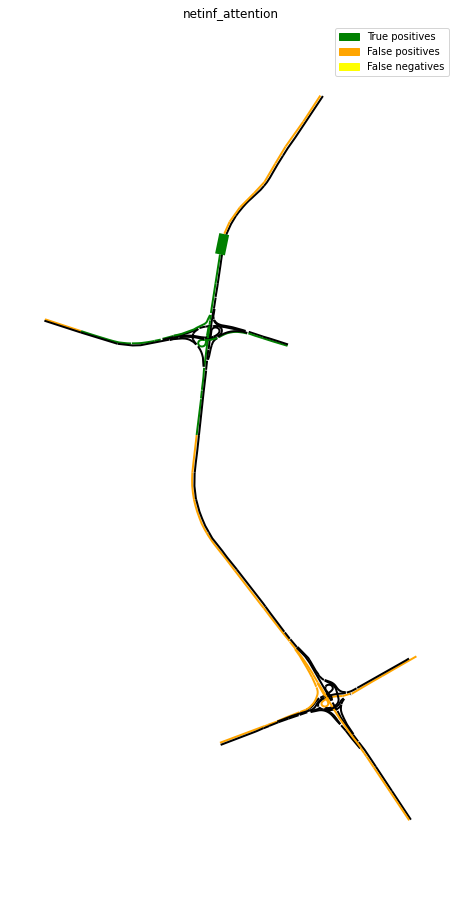

In [80]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'netinf_attention')

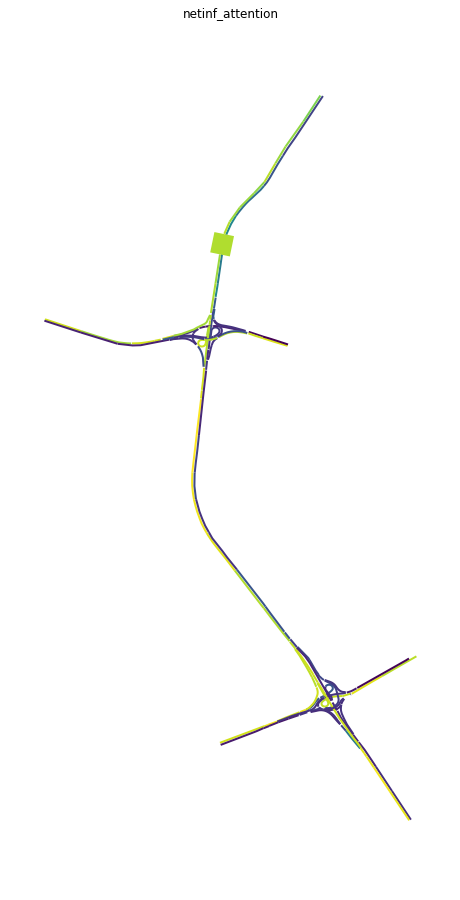

In [81]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

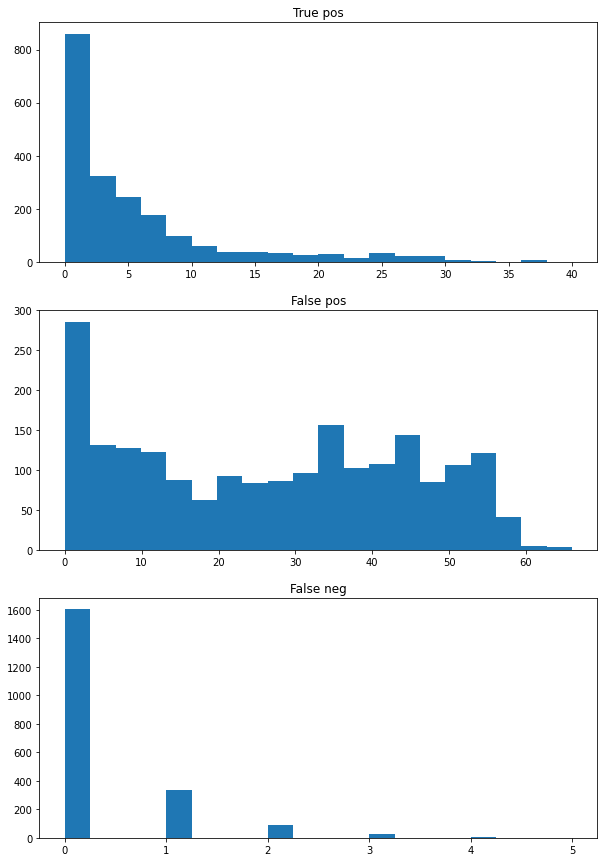

In [82]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Inf-DCRNN

In [83]:
focus_model = 'inf_dcrnn'

In [84]:
full_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  2.556521  1001876.750  0.487889  0.871967  323027.218750  0.482994   
std   0.100629    77356.625  0.011920  0.022980   24012.335938  0.031072   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.767641  302623.625000  0.502300  0.947193  0.549859  0.414723   
std   0.025426   18511.802734  0.019142  0.005140  0.028061  0.023823   

                
          rcll  
mean  0.963394  
std   0.011511

In [85]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  16.841446  6.600006e+06  0.487889  5.744206  2.127988e+06  0.482994   
std    0.662907  5.095979e+05  0.011920  0.151382  1.581847e+05  0.031072   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  5.056948  1.993576e+06  0.502300  0.652125  0.549859  0.414723  0.963394  
std   0.167498  1.219492e+05  0.019142  0.033861  0.028061  0.023823  0.011511

In [86]:
not_upstream_test_df[focus_model]

end            start            speed            class                
      mae mape Mmape   mae mape Mmape   mae mape Mmape   acc   f1 prcsn rcll
mean  0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   1.0  0.0   0.0  0.0
std   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   0.0  0.0

In [87]:
multilane_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.874003  827007.312500  0.492386  0.994478  274056.718750  0.496038   
std   0.147594   90750.648438  0.016554  0.030982   28271.152344  0.029676   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.873769  250017.687500  0.514499  0.949981  0.626429  0.501313   
std   0.038215   21340.359375  0.024100  0.005860  0.031343  0.030258   

                
          rcll  
mean  0.957349  
std   0.013992

In [88]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.146204  1.227880e+06  0.474506  0.713633  386317.187500  0.444176   
std   0.085337  7.214227e+04  0.028674  0.025984   21973.527344  0.042435   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.630481  370612.125000  0.465995  0.943589  0.404478  0.276234   
std   0.019070   17511.898438  0.008015  0.004242  0.021561  0.014675   

                
          rcll  
mean  0.981381  
std   0.005290

In [89]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.091002  1.309790e+06  0.494816  1.070670  424536.500000  0.494774   
std   0.132705  1.039978e+05  0.013680  0.033039   33125.101562  0.029021   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  0.942866  394473.437500  0.508545  0.930966  0.509533  0.374968  0.95771  
std   0.029503   24052.923828  0.023416  0.006602  0.027483  0.022635  0.01363

In [90]:
not_highway_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  1.672625  492666.90625  0.472174  0.543362  155156.53125  0.456273   
std   0.051721   39343.56250  0.021060  0.008034   11193.81250  0.040109   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.477864  150727.312500  0.488133  0.974028  0.668951  0.542893   
std   0.019072   10517.794922  0.010596  0.002807  0.028989  0.027102   

                
          rcll  
mean  0.976286  
std   0.007438

In [91]:
spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.237894  977127.125000  0.490852  1.123605  324989.937500  0.482405   
std   0.083290   83493.570312  0.013064  0.024873   26978.640625  0.027754   

         speed                              class                               
           mae           mape     Mmape       acc       f1     prcsn      rcll  
mean  0.935557  274607.500000  0.505701  0.950639  0.65810  0.531746  0.962435  
std   0.023965   19153.007812  0.021032  0.005259  0.02853  0.027481  0.011494

In [92]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  1.296784  1.047634e+06  0.422096  0.406733  319398.468750  0.496076   
std   0.154718  1.360721e+05  0.055295  0.041511   40115.496094  0.133018   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.457196  354420.437500  0.426768  0.940821  0.119713  0.071827   
std   0.029466   28062.972656  0.027689  0.004934  0.009550  0.005507   

                
          rcll  
mean  0.984694  
std   0.012074

In [93]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  36.758457  0.487889  0.487889  13.118016  0.482994  0.482994  10.981713   
std    1.124443  0.011920  0.011920   0.263333  0.031072  0.031072   0.458330   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.502300  0.502300  0.963394  0.988603   1.0  0.963394  
std   0.019142  0.019142  0.011511  0.004034   0.0  0.011511

In [94]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.218068  1.041084e+06   NaN  0.392732  335668.500000   NaN  0.367926   
std   0.094049  8.038380e+04   NaN  0.029194   24952.011719   NaN  0.022506   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  314466.437500   NaN  0.946559  0.0   0.0  0.0  
std    19236.248047   NaN  0.005425  0.0   0.0  0.0

In [95]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.89	 0.81	 0.81	 1.00	 5.43	 20.84	 8.27
1:	 0.79	 0.67	 0.67	 0.99	 5.47	 22.10	 8.28
2:	 0.70	 0.58	 0.55	 0.99	 6.17	 22.59	 8.33
3:	 0.64	 0.54	 0.49	 0.99	 6.71	 23.16	 8.03
4:	 0.60	 0.52	 0.45	 0.99	 7.00	 24.12	 7.86
5:	 0.55	 0.49	 0.40	 0.99	 7.23	 24.99	 7.69
6:	 0.53	 0.48	 0.37	 0.99	 7.60	 25.15	 7.66
7:	 0.51	 0.48	 0.36	 0.99	 8.03	 24.94	 7.52
8:	 0.47	 0.47	 0.33	 0.98	 8.37	 24.27	 7.25
9:	 0.46	 0.49	 0.32	 0.96	 8.84	 24.08	 6.87
10:	 0.43	 0.50	 0.30	 0.96	 9.17	 23.38	 6.38


In [96]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 1.00	 1.00	 1.00	 1.00	 5.19	 19.52	 7.23
1:	 1.00	 0.99	 1.00	 0.99	 5.66	 23.86	 8.09
2:	 1.00	 0.99	 1.00	 0.99	 7.13	 26.92	 9.48
3:	 1.00	 0.99	 1.00	 0.99	 8.46	 29.55	 10.00
4:	 1.00	 0.99	 1.00	 0.99	 9.47	 33.54	 10.59
5:	 1.00	 0.99	 1.00	 0.99	 10.22	 37.10	 11.07
6:	 1.00	 0.99	 1.00	 0.99	 11.79	 39.84	 12.04
7:	 1.00	 0.99	 1.00	 0.99	 14.04	 42.42	 12.96
8:	 1.00	 0.98	 1.00	 0.98	 16.72	 44.77	 14.07
9:	 0.99	 0.96	 1.00	 0.96	 20.16	 49.03	 14.49
10:	 0.99	 0.96	 1.00	 0.96	 24.25	 53.17	 14.91


Text(0.5, 1.0, 'inf_dcrnn')

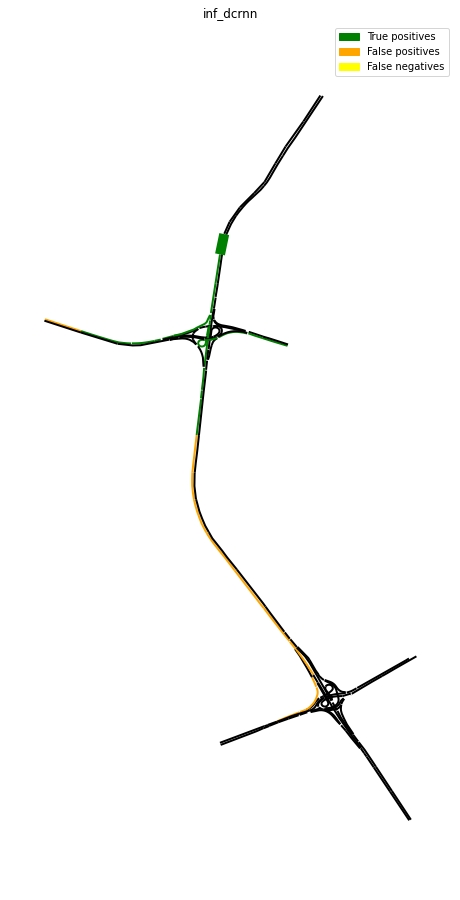

In [97]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_dcrnn')

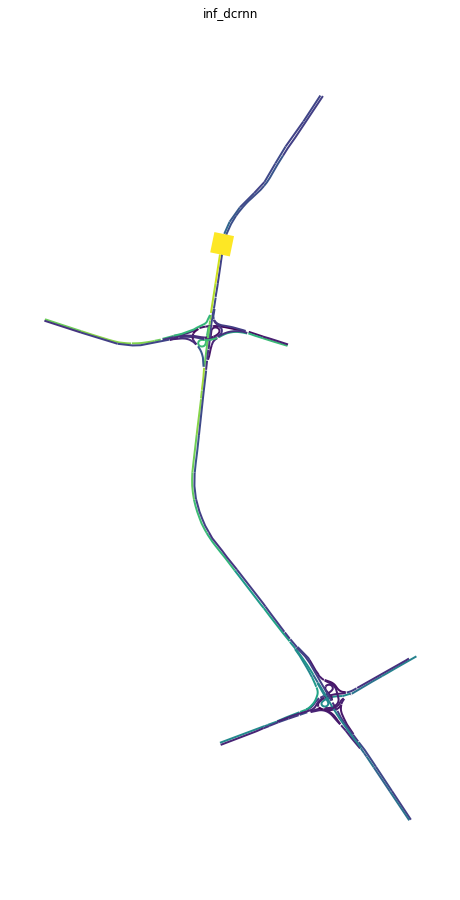

In [98]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

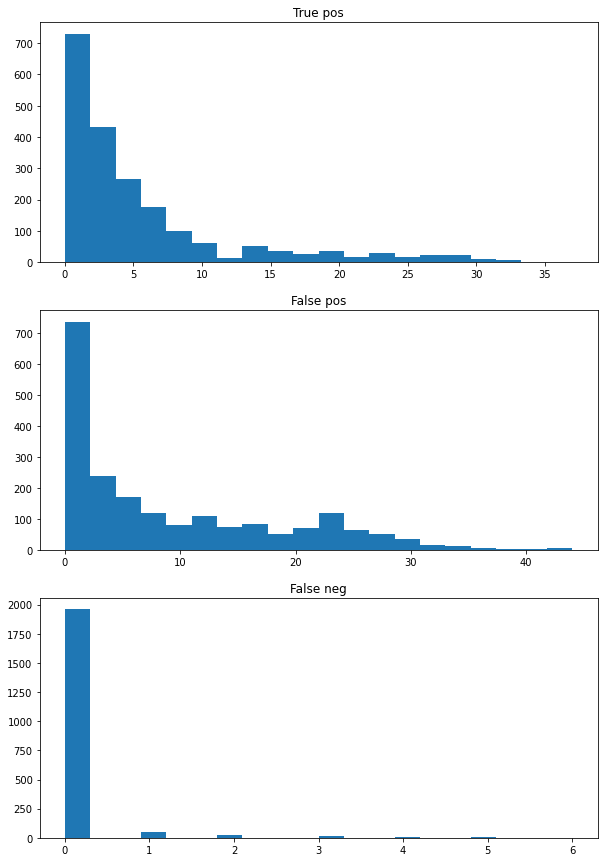

In [99]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')

